# Trajectory Recommendation using POI Ranking and Active Learning

## 1. Overview

1. Rank POIs using rankSVM
1. Recommend a set of POIs given (start, end, length)

In [1]:
% matplotlib inline

import os, re, sys, time, pickle, tempfile
import math, random, itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sop
from joblib import Parallel, delayed

In [2]:
random.seed(987654321) # control random choice when splitting training/testing set
np.random.seed(987654321)
ranksvm_dir = '$HOME/work/ranksvm'

In [3]:
data_dir = 'data/data-ijcai15'
#fvisit = os.path.join(data_dir, 'userVisits-Osak.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Osak.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Glas.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Glas.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')
fvisit = os.path.join(data_dir, 'userVisits-Toro.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Toro.csv')

In [4]:
suffix = fvisit.split('-')[-1].split('.')[0]
fseqpart = os.path.join(data_dir, 'seqPart-' + suffix + '.pkl')

In [5]:
visits = pd.read_csv(fvisit, sep=';')
coords = pd.read_csv(fcoord, sep=';')
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID') # merge data frames according to column 'photoID'
#traj.head()

In [6]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_poi = traj['poiID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
pd.DataFrame({'#photo': num_photo, '#user': num_user, '#poi': num_poi, '#seq': num_seq, \
              '#photo/user': num_photo/num_user, '#seq/user': num_seq/num_user}, index=[str(suffix)])

,#photo,#photo/user,#poi,#seq,#seq/user,#user
Toro,39419,28.257348,29,6057,4.341935,1395


## 2.1 Compute POI Information

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [7]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)

Extract POI category and visiting frequency.

In [8]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)

In [9]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
poi_all.head()
#poi_all.to_csv(fpoi, index=True)

,poiTheme,poiFreq,poiLon,poiLat
poiID,,,,
1,Sport,3506,-79.379243,43.643183
2,Sport,609,-79.418634,43.632772
3,Sport,688,-79.380045,43.662175
4,Sport,3056,-79.389290,43.641297
6,Cultural,986,-79.392396,43.653662


## 2.2 Construct Travelling Sequences

In [10]:
seq_all = traj[['userID', 'seqID', 'poiID', 'dateTaken']].copy().groupby(['userID', 'seqID', 'poiID'])\
          .agg([np.min, np.max, np.size])
seq_all.columns = seq_all.columns.droplevel()
seq_all.reset_index(inplace=True)
seq_all.rename(columns={'amin':'arrivalTime', 'amax':'departureTime', 'size':'#photo'}, inplace=True)
seq_all['poiDuration(sec)'] = seq_all['departureTime'] - seq_all['arrivalTime']
seq_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,#photo,poiDuration(sec)
0,10007579@N00,1,30,1346844688,1346844688,1,0
1,10012675@N05,2,6,1142731848,1142732445,4,597
2,10012675@N05,3,6,1142916492,1142916492,1,0
3,10012675@N05,4,13,1319327174,1319332848,9,5674
4,10014440@N06,5,24,1196128621,1196128878,3,257


In [11]:
seq_stats = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_stats.reset_index(inplace=True)
seq_stats.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_stats.set_index('seqID', inplace=True)
seq_stats.head()

,userID,seqLen
seqID,,
1,10007579@N00,1
2,10012675@N05,1
3,10012675@N05,1
4,10012675@N05,1
5,10014440@N06,1


In [12]:
def extract_seq(seqid, seq_all):
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort_values(by=['arrivalTime'], ascending=True, inplace=True)
    return seqi['poiID'].tolist()

In [13]:
def calc_poi_info(seqid_set, seq_all, poi_all):
    poi_info = seq_all[seq_all['seqID'].isin(seqid_set)][['poiID', 'poiDuration(sec)']].copy()
    poi_info = poi_info.groupby('poiID').agg([np.mean, np.size])
    poi_info.columns = poi_info.columns.droplevel()
    poi_info.reset_index(inplace=True)
    poi_info.rename(columns={'mean':'avgDuration(sec)', 'size':'popularity'}, inplace=True)
    poi_info.set_index('poiID', inplace=True)
    poi_info['poiTheme'] = poi_all.loc[poi_info.index, 'poiTheme']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
    return poi_info.copy()

## 2.3 Train vs. Query vs. Test Data

Split sequences into training set and test data.

In [14]:
train_percent = 0.3
query_percent = 0.5
seqid_set_train0 = []
seqid_set_query0 = []
seqid_set_test0 = []
query_id_dict = dict()

In [15]:
seqid_set_exp = seq_stats[seq_stats['seqLen'] > 2].index.tolist()
seq_idx = np.arange(len(seqid_set_exp))
np.random.shuffle(seq_idx)
ntrain = int(train_percent * len(seq_idx))
nquery = int(query_percent * len(seq_idx))
seqid_set_train0 = seqid_set_exp[:ntrain]
seqid_set_query0 = seqid_set_exp[ntrain:ntrain+nquery]
seqid_set_test0 = seqid_set_exp[ntrain+nquery:]

In [16]:
print('#seq in total:', len(seqid_set_exp))
print('#seq for training:', ntrain)
print('#seq for querying:', nquery)
print('#seq for testing:', len(seqid_set_exp)-ntrain-nquery)

#seq in total: 335
#seq for training: 100
#seq for querying: 167
#seq for testing: 68


In [17]:
seqs_exp = [extract_seq(seqid, seq_all) for seqid in seqid_set_exp]
keys = [(seq[0], seq[-1], len(seq)) for seq in seqs_exp]
cnt = 0
for key in keys:
    if key not in query_id_dict:
        query_id_dict[key] = cnt
        cnt += 1

### Training Data

Training data are generated as follows:
1. each input tuple $(\text{startPOI}, \text{endPOI}, \text{#POI})$ form a `query` (in IR terminology).
1. the label of a specific POI is the number of presence of that POI in a specific `query`.
1. ~~the label of all absence POIs in a specific `query` got a label 0.~~ unobserved for absence POIs in a specific `query`.

### Test Data

Test data are generated the same way as training data, ~~except that the labels of testing data (unknown) could be arbitrary values as suggested in [libsvm FAQ](http://www.csie.ntu.edu.tw/~cjlin/libsvm/faq.html#f431).~~
Yes, but the reported accuracy is calculated based on these values, so just use the same procedure to generate test data.

In [18]:
def gen_data_df(seqid_set, seq_all, poi_info, query_id_dict):
    columns = ['label', 'queryId', 'popularity', 'avgDuration(sec)']
    poi_list = poi_info.index
    train_df = pd.DataFrame(data=np.zeros((len(poi_list), len(columns)), dtype=np.float), \
                            index=poi_list, columns=columns)
    train_df['popularity'] = poi_info.loc[train_df.index, 'popularity']
    train_df['avgDuration(sec)'] = poi_info.loc[train_df.index, 'avgDuration(sec)']
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        key = (seq[0], seq[-1], len(seq))
        qid = query_id_dict[key]
        for poi in seq:
            train_df.loc[poi, 'queryId'] = qid
            train_df.loc[poi, 'label'] += 1
    return train_df

## 2.4 Ranking POIs using rankSVM

RankSVM (zip file) can be downloaded [here](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/libsvm-ranksvm-3.20.zip), please read `README.ranksvm` in the zip file for installation instructions.

Below is a python wrapper of the `svm-train` and `svm-predict` commands of rankSVM.

In [19]:
# python wrapper of rankSVM
class RankSVM:
    def __init__(self, bin_dir):
        dir_ = !echo $bin_dir  # deal with environmental variables in path
        assert(os.path.exists(dir_[0]))
        self.bin_dir = dir_[0]
        
        # create named tmp files for model and feature scaling parameters
        self.fmodel = None
        self.fscale = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fmodel = fd.name
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fscale = fd.name
            
        #print('fmodel:', self.fmodel)
        #print('fscale:', self.fscale)
    
    
    def __del__(self):
        # remove tmp files
        if self.fmodel is not None and os.path.exists(self.fmodel):
            os.unlink(self.fmodel)
        if self.fscale is not None and os.path.exists(self.fscale):
            os.unlink(self.fscale)
    
    
    def train(self, train_df, cost=1):
        # cost is parameter C in SVM
        # write train data to file
        ftrain = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain = fd.name
            for idx in train_df.index:
                line = str(train_df.loc[idx, 'label'])
                line += ' qid:' + str(int(train_df.loc[idx, 'queryId']))
                line += ' 1:' + str(train_df.loc[idx, 'popularity'])
                line += ' 2:' + str(train_df.loc[idx, 'avgDuration(sec)'])
                fd.write(line + '\n')
        
        # feature scaling
        ftrain_scaled = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain_scaled = fd.name
        result = !$self.bin_dir/svm-scale -s $self.fscale $ftrain > $ftrain_scaled
                
        # train rank svm and generate model file, if the model file exists, rewrite it
        #n_cv = 10  # parameter k for k-fold cross-validation, NO model file will be generated in CV mode
        #result = !$self.bin_dir/svm-train -c $cost -v $n_cv $ftrain $self.fmodel
        #print('Training...')
        result = !$self.bin_dir/svm-train -c $cost $ftrain_scaled $self.fmodel
        #print('Done')

        # remove train data file
        os.unlink(ftrain)
        os.unlink(ftrain_scaled)
        #print('ftrain:', ftrain)
        #print('ftrain_scaled:', ftrain_scaled)
    
    
    def predict(self, test_df):
        if self.fmodel is None or not os.path.exists(self.fmodel):
            print('Model should be trained before predicting')
            return
        
        # write test data to file
        ftest = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftest = fd.name
            for idx in test_df.index:
                line = str(test_df.loc[idx, 'label'])
                line += ' qid:' + str(int(test_df.loc[idx, 'queryId']))
                line += ' 1:' + str(test_df.loc[idx, 'popularity'])
                line += ' 2:' + str(test_df.loc[idx, 'avgDuration(sec)'])
                fd.write(line + '\n')
                
        # feature scaling
        ftest_scaled = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            ftest_scaled = fd.name
        result = !$self.bin_dir/svm-scale -r $self.fscale $ftest > $ftest_scaled
            
        # generate prediction file
        fpredict = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            fpredict = fd.name
            
        # predict using trained model and write prediction to file
        result = !$self.bin_dir/svm-predict $ftest_scaled $self.fmodel $fpredict
        print('%-30s  %s' % (result[0], result[1]))
        
        # generate prediction DataFrame from prediction file
        poi_rank_df = pd.read_csv(fpredict, header=None)
        poi_rank_df.rename(columns={0:'rank'}, inplace=True)
        poi_rank_df['poiID'] = test_df.index
        poi_rank_df.set_index('poiID', inplace=True)
        
        # remove test file and prediction file
        os.unlink(ftest)
        os.unlink(ftest_scaled)
        os.unlink(fpredict)
        #print('ftest:', ftest)
        #print('ftest_scaled:', ftest_scaled)
        #print('fpredict:', fpredict)
        
        return poi_rank_df

# 3. Recommend Trajectory

In [20]:
def calc_F1score(seq_act, seq_rec):
    assert(len(seq_act) > 0)
    assert(len(seq_rec) > 0)
    
    act_set = set(seq_act)
    rec_set = set(seq_rec)
    intersect = act_set & rec_set
    
    recall = len(intersect) / len(act_set)
    precision = len(intersect) / len(rec_set)
    F1score = 2. * precision * recall / (precision + recall)
    
    return F1score

In [21]:
def evaluate(poi_rank_df, seqid_set, seq_all):
    pois = poi_rank_df.index
    ranks = poi_rank_df['rank'].get_values()
    ranked_poi = pois[ranks.argsort()][::-1]  # highest rank --> lowest rank 
    
    F1scores = []
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        poi_rec = [p for p in ranked_poi if p not in {seq[0], seq[-1]}][:len(seq)-2]
        seq_rec = [seq[0]] + poi_rec + [seq[-1]]
        F1 = calc_F1score(seq, seq_rec)
        F1scores.append(F1)
        
    return F1scores

## 3.1 Leave-one-out

Compare the performance with ijcai15 paper use the same leave-one-out evaluation strategy.  

In [ ]:
def leave1out(seqid_set_all, seq_all, poi_all, query_id_dict):
    F1scores_train = []
    F1scores_test  = []
    
    for i in range(len(seqid_set_all)):
        seqid_set_train = seqid_set_all[:i] + seqid_set_all[i+1:]
        seqid_set_test = [seqid_set_all[i]]
        poi_info_train = calc_poi_info(seqid_set_train, seq_all, poi_all)
        train_df = gen_data_df(seqid_set_train, seq_all, poi_info_train, query_id_dict)
        poi_info_test = calc_poi_info(seqid_set_test, seq_all, poi_all)
        test_df = gen_data_df(seqid_set_test, seq_all, poi_info_test, query_id_dict)
        
        # training rankSVM
        C = 1000
        ranksvm = RankSVM(ranksvm_dir)
        ranksvm.train(train_df, C)
        
        # compute training accuracy
        poi_rank_train = ranksvm.predict(train_df)
        F1scores = evaluate(poi_rank_train, seqid_set_train, seq_all)
        F1scores_train.append(F1scores)
        
        # compute testing accuracy
        poi_rank_test = ranksvm.predict(test_df)
        F1scores = evaluate(poi_rank_test, seqid_set_test, seq_all)
        F1scores_test.append(F1scores)
        
    return F1scores_train, F1scores_test

In [ ]:
F1_l1o_train, F1_l1o_test = leave1out(seqid_set_exp, seq_all, poi_all, query_id_dict)

In [ ]:
plot_evaluation(F1_l1o_train, F1_l1o_test)

## 3.2 Random Baseline

Choose a sequence to query uniformly at random, i.e. passive learning.

In [22]:
def random_baseline(seqid_set_train, seqid_set_query, seqid_set_test, seq_all, poi_all, query_id_dict):
    seq_idx = np.arange(len(seqid_set_query))
    np.random.shuffle(seq_idx)
    
    F1scores_train = []
    F1scores_test  = []
    poi_info_test = calc_poi_info(seqid_set_test, seq_all, poi_all)
    test_df = gen_data_df(seqid_set_test, seq_all, poi_info_test, query_id_dict)
    
    while len(seqid_set_query) > 0:
        # compute features for training
        poi_info_train = calc_poi_info(seqid_set_train, seq_all, poi_all)
        train_df = gen_data_df(seqid_set_train, seq_all, poi_info_train, query_id_dict)
        
        # training rankSVM
        #C = 100
        #C = 300
        C = 1000
        ranksvm = RankSVM(ranksvm_dir)
        ranksvm.train(train_df, C)
        
        # compute training accuracy
        poi_rank_train = ranksvm.predict(train_df)
        F1scores = evaluate(poi_rank_train, seqid_set_train, seq_all)
        F1scores_train.append(F1scores)
        
        # compute testing accuracy
        poi_rank_test = ranksvm.predict(test_df)
        F1scores = evaluate(poi_rank_test, seqid_set_test, seq_all)
        F1scores_test.append(F1scores)
        
        # query strategy
        idx = -1
        seqid_set_train.append(seqid_set_query[idx])
        del seqid_set_query[idx]
        
    return F1scores_train, F1scores_test

## 3.3 Least Confident Query Strategy

## 3.4 Evaluation

In [23]:
def plot_evaluation(F1_train_list, F1_test_list):
    assert(len(F1_train_list) == len(F1_test_list))
    plt.figure(figsize=[15, 18])
    plt.subplot(3, 1, 1)
    plt.xlabel('#Query')
    plt.ylabel('Train F1')
    plt.boxplot(F1_train_list)
    plt.plot(np.arange(1, len(F1_train_list)+1), [np.mean(x) for x in F1_train_list], color='r')
    xticks = [10*x for x in range(math.ceil(len(F1_train_list)/10))]
    plt.xticks(xticks, xticks) # xticks starts from 1
    
    
    plt.subplot(3, 1, 2)
    plt.xlabel('#Query')
    plt.ylabel('Test F1')
    plt.boxplot(F1_test_list)
    plt.plot(np.arange(1, len(F1_test_list)+1), [np.mean(x) for x in F1_test_list], color='r')
    plt.xticks(xticks, xticks)
    
    plt.subplot(3, 1, 3)
    plt.xlabel('#Query')
    plt.ylabel('F1')
    plt.ylim([0.3, 0.95])
    plt.plot(np.arange(len(F1_train_list)), [np.mean(x) for x in F1_train_list], label='Train F1 - Mean', marker='s')
    plt.plot(np.arange(len(F1_train_list)), [np.median(x) for x in F1_train_list], label='Train F1 - Median', marker='o')
    plt.plot(np.arange(len(F1_test_list)), [np.mean(x) for x in F1_test_list], label='Test F1 - Mean', marker='^')
    plt.plot(np.arange(len(F1_test_list)), [np.median(x) for x in F1_test_list], label='Test F1 - Median', marker='d')
    plt.legend(loc='lower right')

In [24]:
seqid_set_train = seqid_set_train0.copy()
seqid_set_query = seqid_set_query0.copy()
seqid_set_test  = seqid_set_test0.copy()

In [25]:
F1_rand_train, F1_rand_test = random_baseline(seqid_set_train, seqid_set_query, seqid_set_test, seq_all, query_id_dict)

Pairwise Accuracy = 100%        MeanNDCG (LETOR) = 1
Pairwise Accuracy = 100%        MeanNDCG (LETOR) = 1
Pairwise Accuracy = 100%        MeanNDCG (LETOR) = 1
Pairwise Accuracy = 100%        MeanNDCG (LETOR) = 1
Pairwise Accuracy = 100%        MeanNDCG (LETOR) = 1
Pairwise Accuracy = 76%         MeanNDCG (LETOR) = 0.930629
Pairwise Accuracy = 100%        MeanNDCG (LETOR) = 1
Pairwise Accuracy = 76%         MeanNDCG (LETOR) = 0.930629
Pairwise Accuracy = 100%        MeanNDCG (LETOR) = 1
Pairwise Accuracy = 92%         MeanNDCG (LETOR) = 0.975756
Pairwise Accuracy = 100%        MeanNDCG (LETOR) = 1
Pairwise Accuracy = 92%         MeanNDCG (LETOR) = 0.975756
Pairwise Accuracy = 100%        MeanNDCG (LETOR) = 1
Pairwise Accuracy = 96%         MeanNDCG (LETOR) = 1
Pairwise Accuracy = 100%        MeanNDCG (LETOR) = 1
Pairwise Accuracy = 100%        MeanNDCG (LETOR) = 1
Pairwise Accuracy = 100%        MeanNDCG (LETOR) = 1
Pairwise Accuracy = 100%        MeanNDCG (LETOR) = 1
Pairwise Accuracy 

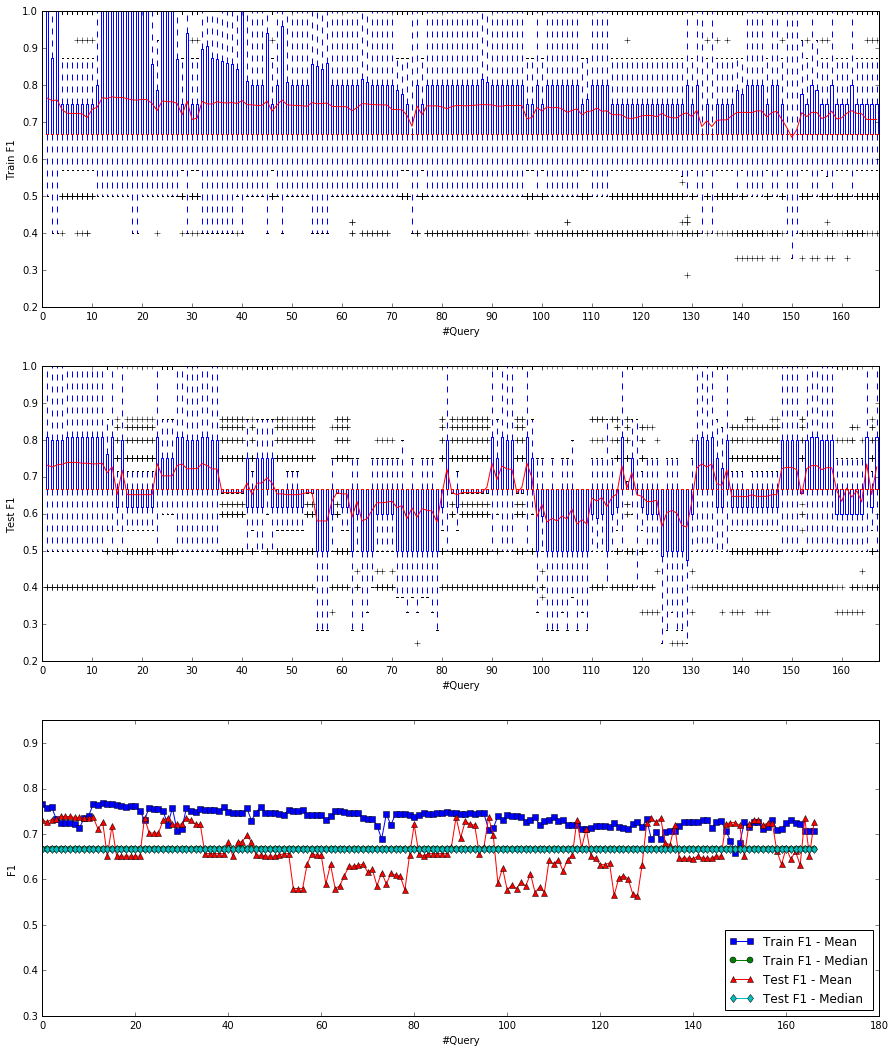

In [26]:
plot_evaluation(F1_rand_train, F1_rand_test)